In [1]:
%config Completer.use_jedi = False

In [31]:
!pip install gym[atari]
!pip install stable-baselines3[extra]

  Using cached opencv_python-4.5.5.62-cp36-abi3-win_amd64.whl (35.4 MB)
  Using cached atari_py-0.2.6-cp39-cp39-win_amd64.whl


Reason for being yanked: re-release with new wheels


In [222]:
!pip install tqdm

  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)


In [1]:
import numpy as np
import torch
from atari_py import import_roms
from PIL import Image
import torch.nn as nn
import copy
from torch.optim import RMSprop
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import torchvision.transforms.functional as TF
from collections import deque
from queue import Queue
from tqdm import tqdm as tq
import random
import os
from gym.core import Env


D:\Anaconda3\envs\SKYNET\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'D:\Anaconda3\envs\SKYNET\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


'__main__'

In [3]:
import_roms.import_roms('.\Roms\ROMS\ROMS')

copying adventure.bin from .\Roms\ROMS\ROMS\Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to D:\Anaconda3\envs\SKYNET\lib\site-packages\atari_py\atari_roms\adventure.bin
copying air_raid.bin from .\Roms\ROMS\ROMS\Air Raid (Men-A-Vision) (PAL) ~.bin to D:\Anaconda3\envs\SKYNET\lib\site-packages\atari_py\atari_roms\air_raid.bin
copying alien.bin from .\Roms\ROMS\ROMS\Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to D:\Anaconda3\envs\SKYNET\lib\site-packages\atari_py\atari_roms\alien.bin
copying amidar.bin from .\Roms\ROMS\ROMS\Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to D:\Anaconda3\envs\SKYNET\lib\site-packages\atari_py\atari_roms\amidar.bin
copying assault.bin from .\Roms\ROMS\ROMS\Assault (AKA Sky Alien) (1983) (Bomb - Onbase) (CA281).bin to D:\Anaconda3\envs\SKYNET\lib\site-packages\atari_py\atari_roms\assault.bin
copying asterix.bin from .\Roms\ROMS\ROMS\Asterix (AKA Taz) (07-27-1983) (Atari, Jerom

In [4]:
ENv=gym.make('Breakout-v0')
type(ENv)

gym.wrappers.time_limit.TimeLimit

In [3]:
class atari_env_wrapper():
    
    """ Wrapper Class to wrap around actual env and 
    return processed next state,done and reward info
    so Qnet can ingest processed environment state to produce
    actions. Example:
    
    In Atari games the Kframes argument sets the number of frames
    to be used by the agent to produce an action.the agent repeats
    the action chosen for kframes=4 consecutive atari frames
    and concats the 4 produced observation into one tensor(frames) of
    shape 4 by 84 by 84 -4 greyscale images of size 4 by 4.
    
    The reset() method resets the wrapped atari env and also executes
    a random action kframes=4 times to produce the first video"""
    
   
    def __init__(self,env,kframes=4):
        self.env=env
        self.kframes=kframes
        self.action_space=self.env.action_space
        
        
    def preproc(self,frames):
        out=torch.tensor(np.transpose(frames,(0,3,1,2)))/255.
        out=TF.rgb_to_grayscale(out)
        out=out.squeeze()
        out=TF.resize(out,(110,84))
        out=TF.crop(out,top=110-84,left=0,height=84,width=84)
        return out
        
    def step(self,action):
        frames,rews,dones=[],0,[]
        for i in range(self.kframes):
            frame,rew,done,_=self.env.step(action)
            frames.append(frame)
            rews+=rew
            dones.append(done)
        return (self.preproc(np.stack(frames)),rews,any(dones))
    
    ## take 1 random step to produce k=4 frames for input to the Qnet
    def reset(self):
        self.env.reset()
        init_act=self.env.action_space.sample()
        return self.step(init_act)
        
        
        
        
class Q_net(nn.Module):
    
    def __init__(self,n_actions=4,act=nn.ReLU(),kframes=4):
        super(Q_net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(kframes, 16, 8, 4),act)
      
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 4, 2),act)
        self.pool1=nn.AdaptiveAvgPool2d(1)
        self.fc1=nn.Sequential(nn.Linear(32,256),act)
        self.fc2=nn.Linear(256,n_actions)
        
    
    def forward(self, x):
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.pool1(out)
        out=out.squeeze()
        out=self.fc1(out)
        out=self.fc2(out)
        return out
        
            
                    

class atari_DQN():
    """ The Class implements DQN algorithm for atari games.Experiance is generated by acting epsilon greedily wrt the currently stored Q (action value) function
         policy evaluation is done by minimizing bellman error from generated experiance,policy improvement is done by epsilon greedy sampling of actions.
            """
    def __init__(self,Q_net_arch,optimizer,kframes,device=torch.device('cuda'),lr=0.001,training_begins=10000,buffer_size=100000,update_tgt_lag=1000,batch_size=32,
                 env_wrapper=atari_env_wrapper(env=gym.make('Breakout-v0'),kframes=4),gamma=0.99,bellman_loss=nn.MSELoss(),eps_start=1.0,eps_end=0.1):
       
        self.batch_size=batch_size
        self.buffer=self.replay_buffer(buffer_size)
        self.env_wrapper=env_wrapper(env=gym.make('Breakout-v0'),kframes=kframes)
        self.device=torch.device('cpu') if not torch.cuda.is_available() else device
        print(f'using device:{self.device}')
        self.Q_net=Q_net_arch(kframes=kframes).to(device)
        self.Q_targ=copy.deepcopy(self.Q_net)
        self.optimizer=optimizer(self.Q_net.parameters(),lr)
        self.eps_start=eps_start
        self.eps_end=eps_end
        self.gamma=gamma
        self.bellman_loss=bellman_loss.to(self.device)
        self.update_tgt_lag=update_tgt_lag
        self.training_begins=training_begins
        self.rew_per_epi_log='reward_per_episode_log.csv'
    
    class replay_buffer():
        def __init__(self,max_size):
            self.max_size=max_size
            self.items=[]
            
        def add_item(self,item):
            self.items.append(item)
            if len(self.items)>self.max_size:
                self.items.pop(0)
                
        def sample_items(self,batch_size):
            return random.sample(self.items,min(batch_size,len(self.items)))
            
            
    def Q_net_forward(self,proc_frames_batch):
        return self.Q_net(proc_frames_batch.to(self.device))
    
    def Q_targ_forward(self,proc_frames_batch):
        return self.Q_targ(proc_frames_batch.to(self.device))
        
        
    def select_action(self,proc_frames,eps):
        ## act epsilon greedily wrt current Q function
        if np.random.rand()<=eps:
            return self.env_wrapper.action_space.sample()
        else:
            with torch.no_grad():
                   return torch.argmax(self.Q_net_forward(proc_frames.unsqueeze(0)))
                
  
        
    def eval_agent(self,eps=0.05,epis=100):
        all_rews=[]
        for ep in range(epis):
            _,epi_rew,done=self.env_wrapper.reset()
            while not done:
                action=self.select_action(frames,eps)
                _,rew,done=self.env_wrapper.step(action)
                epi_rew+=rew
            all_rews.append(epi_rew)
        all_rews=np.array(all_rews)
        
        return {'mean_rew_per_epi':all_rews.mean(),
                'std_dev_rew':all_rews.std()} 
                
                
    def train(self,timesteps):
        ## set up decay factor for random exploration-epsilon
        eps_anneal_factor=np.exp(np.log(self.eps_end/self.eps_start)/(-self.training_begins+timesteps))
        eps=self.eps_start
        print(eps_anneal_factor)
        epis,total_rew,episode_rew,epoch_t_minus1=0,0,0,0
        proc_frames,rew,done=self.env_wrapper.reset()
       
        for t in tq(range(timesteps),position=0,leave=True):
            proc_frames_t=proc_frames
            a=self.select_action(proc_frames_t,eps)
           
            proc_frames,rew,done=self.env_wrapper.step(a)
            total_rew+=rew
            episode_rew+=rew
            
            if done:
                with torch.no_grad():
                    target=torch.tensor(rew).to(self.device)
                    proc_frames,rew,done=self.env_wrapper.reset()
                epis+=1
                if epis%10==0:
                    row={'episode':epis,'reward_per_episode':total_rew/epis,'reward_this_episode':episode_rew,'epsilon':eps}
                    print(row)
                    #df=pd.DataFrame(row)
                    #df.to_csv(self.rew_per_epi_log, mode='a', header=not os.path.exists(self.rew_per_epi_log))
                episode_rew=0    
                
            else:
                proc_frames_t_plus1=proc_frames
                a_prime=self.select_action(proc_frames_t_plus1,eps)
                with torch.no_grad():
                    ## need an extra leading dim to do forwarf pass for 1 sample minibatch
                    target=rew+self.gamma*self.Q_targ_forward(proc_frames_t_plus1.unsqueeze(0))[a_prime]
                
            ## add the tuple of Q_input and taget to replay buffer    
            self.buffer.add_item((proc_frames_t,a,target))
            if t>self.training_begins:
                train_steps=t-self.training_begins
                if train_steps==0:
                    print('training_begins')
                batch=self.buffer.sample_items(self.batch_size)
                x_b,a_b,y_b=zip(*batch)
                #calculating q(x,a) for all actions
                out_b=self.Q_net_forward(torch.stack(x_b))
                #calculating q(x,a) for the action selected
                out_b=torch.stack([out[a] for out,a in zip(out_b,a_b)])
                #calculating bellman error for minibatch and do backward step
                bellman_loss=self.bellman_loss(out_b,torch.stack(y_b))
                self.optimizer.zero_grad()
                bellman_loss.backward()
                self.optimizer.step()
                
                ## decay epsilon exploration
                eps=eps*eps_anneal_factor
                
                ## printing loss statistics every n=50 epochs
                epoch_t=(train_steps*self.batch_size)//self.buffer.max_size
                if epoch_t-epoch_t_minus1==1 and epoch_t%100==0:
                    print ({'epoch':epoch_t,'bellman_loss':bellman_loss.detach().item()})
                epoch_t_minus1=epoch_t
                
                ## update the target Q network with a lagged copy of the Q  network
                if t%self.update_tgt_lag==0:
                    self.Q_targ=copy.deepcopy(self.Q_net)
                    
                    
                    

            
            
            
            
            
            
            
            
            
            
            
            
            
            
            
                    
                    
                    
                
                
                
                
                
                
            
            
            
            
        
        
        
        
        
        
        
        
        
        
    
        

In [ ]:
from gym.core import Env

In [9]:
dqn=atari_DQN(Q_net,RMSprop,training_begins=500,buffer_size=1000,lr=0.0001,update_tgt_lag=1000,eps_start=0.3,eps_end=0.05)

using device:cuda


In [4]:
dqn.train(100000)


0.9999819925292799


  1%|▉                                                                         | 1204/100000 [00:37<1:02:25, 26.37it/s]

{'episode': 10, 'reward_per_episode': 1.8, 'reward_this_episode': 2.0, 'epsilon': 0.29625280090086076}


  2%|█▍                                                                        | 2022/100000 [01:06<1:04:13, 25.42it/s]

{'episode': 20, 'reward_per_episode': 1.8, 'reward_this_episode': 2.0, 'epsilon': 0.2919209081988211}


  3%|██▎                                                                       | 3080/100000 [01:45<1:07:58, 23.77it/s]

{'episode': 30, 'reward_per_episode': 1.9666666666666666, 'reward_this_episode': 5.0, 'epsilon': 0.28641701273108194}


  4%|██▊                                                                         | 3631/100000 [02:05<56:48, 28.27it/s]

{'epoch': 100, 'bellman_loss': 0.0007708743796683848}


  4%|██▉                                                                       | 3939/100000 [02:16<1:02:51, 25.47it/s]

{'episode': 40, 'reward_per_episode': 1.925, 'reward_this_episode': 1.0, 'epsilon': 0.28201048847684423}


  5%|███▌                                                                      | 4810/100000 [02:50<1:06:15, 23.94it/s]

{'episode': 50, 'reward_per_episode': 1.84, 'reward_this_episode': 3.0, 'epsilon': 0.2776267603221416}


  6%|████▏                                                                     | 5620/100000 [03:20<1:02:44, 25.07it/s]

{'episode': 60, 'reward_per_episode': 1.85, 'reward_this_episode': 1.0, 'epsilon': 0.27360170914253756}


  6%|████▋                                                                     | 6325/100000 [03:47<1:05:22, 23.88it/s]

{'episode': 70, 'reward_per_episode': 1.7428571428571429, 'reward_this_episode': 1.0, 'epsilon': 0.27015505152096714}


  7%|████▉                                                                     | 6752/100000 [04:04<1:14:19, 20.91it/s]

{'epoch': 200, 'bellman_loss': 0.0008057102095335722}


  7%|█████▏                                                                    | 7088/100000 [04:16<1:09:43, 22.21it/s]

{'episode': 80, 'reward_per_episode': 1.6125, 'reward_this_episode': 2.0, 'epsilon': 0.2664637541892154}


  8%|██████                                                                    | 8198/100000 [05:02<1:03:57, 23.92it/s]

{'episode': 90, 'reward_per_episode': 1.6222222222222222, 'reward_this_episode': 2.0, 'epsilon': 0.2611951326672595}


  9%|██████▉                                                                   | 9407/100000 [05:46<1:09:20, 21.78it/s]

{'episode': 100, 'reward_per_episode': 1.57, 'reward_this_episode': 2.0, 'epsilon': 0.25556084426943076}


 10%|███████▌                                                                    | 9882/100000 [06:04<56:07, 26.76it/s]

{'epoch': 300, 'bellman_loss': 1.7716543879942037e-05}


 11%|███████▋                                                                 | 10501/100000 [06:26<1:03:00, 23.67it/s]

{'episode': 110, 'reward_per_episode': 1.518181818181818, 'reward_this_episode': 2.0, 'epsilon': 0.25058449881274}


 12%|████████▌                                                                | 11644/100000 [07:09<1:04:20, 22.89it/s]

{'episode': 120, 'reward_per_episode': 1.55, 'reward_this_episode': 3.0, 'epsilon': 0.2454795047148731}


 13%|█████████▏                                                               | 12663/100000 [07:47<1:05:20, 22.28it/s]

{'episode': 130, 'reward_per_episode': 1.5615384615384615, 'reward_this_episode': 1.0, 'epsilon': 0.2410117468420766}


 13%|█████████▊                                                                 | 13004/100000 [08:00<52:22, 27.69it/s]

{'epoch': 400, 'bellman_loss': 0.00013647688319906592}


 14%|██████████▏                                                              | 13924/100000 [08:34<1:01:36, 23.28it/s]

{'episode': 140, 'reward_per_episode': 1.5642857142857143, 'reward_this_episode': 2.0, 'epsilon': 0.23560485463735065}


 15%|███████████                                                                | 14777/100000 [09:05<55:47, 25.46it/s]

{'episode': 150, 'reward_per_episode': 1.6, 'reward_this_episode': 1.0, 'epsilon': 0.23200931889891044}


 16%|████████████                                                               | 16131/100000 [09:56<50:57, 27.43it/s]

{'epoch': 500, 'bellman_loss': 0.00020087524899281561}


 16%|████████████▏                                                              | 16176/100000 [09:58<58:38, 23.82it/s]

{'episode': 160, 'reward_per_episode': 1.5875, 'reward_this_episode': 2.0, 'epsilon': 0.22624146719053403}


 17%|████████████▍                                                            | 17068/100000 [10:32<1:20:44, 17.12it/s]

{'episode': 170, 'reward_per_episode': 1.5823529411764705, 'reward_this_episode': 3.0, 'epsilon': 0.2226284067251499}


 18%|█████████████▎                                                             | 17751/100000 [11:01<59:28, 23.05it/s]

{'episode': 180, 'reward_per_episode': 1.5666666666666667, 'reward_this_episode': 1.0, 'epsilon': 0.21991098226740768}


 19%|██████████████                                                             | 18753/100000 [11:40<58:21, 23.20it/s]

{'episode': 190, 'reward_per_episode': 1.568421052631579, 'reward_this_episode': 0.0, 'epsilon': 0.21597468087813104}


 19%|██████████████▍                                                            | 19256/100000 [12:01<53:07, 25.33it/s]

{'epoch': 600, 'bellman_loss': 0.02626863494515419}


 19%|██████████████▌                                                            | 19394/100000 [12:06<51:11, 26.24it/s]

{'episode': 200, 'reward_per_episode': 1.55, 'reward_this_episode': 2.0, 'epsilon': 0.21350373043114354}


 20%|███████████████▏                                                           | 20196/100000 [12:36<54:52, 24.24it/s]

{'episode': 210, 'reward_per_episode': 1.561904761904762, 'reward_this_episode': 1.0, 'epsilon': 0.21044623216360367}


 21%|███████████████▊                                                           | 21016/100000 [13:06<55:10, 23.86it/s]

{'episode': 220, 'reward_per_episode': 1.5818181818181818, 'reward_this_episode': 1.0, 'epsilon': 0.20736155919485358}


 22%|████████████████▎                                                          | 21784/100000 [13:35<54:14, 24.03it/s]

{'episode': 230, 'reward_per_episode': 1.5782608695652174, 'reward_this_episode': 1.0, 'epsilon': 0.20451351685052102}


 22%|████████████████▊                                                          | 22380/100000 [13:57<45:40, 28.33it/s]

{'epoch': 700, 'bellman_loss': 0.05355031415820122}


 23%|████████████████▉                                                          | 22510/100000 [14:02<54:07, 23.86it/s]

{'episode': 240, 'reward_per_episode': 1.5625, 'reward_this_episode': 2.0, 'epsilon': 0.20185720246234107}


 23%|█████████████████▎                                                         | 23086/100000 [14:24<59:04, 21.70it/s]

{'episode': 250, 'reward_per_episode': 1.548, 'reward_this_episode': 2.0, 'epsilon': 0.19975989130760002}


 24%|█████████████████▊                                                         | 23803/100000 [14:58<55:09, 23.02it/s]

{'episode': 260, 'reward_per_episode': 1.5346153846153847, 'reward_this_episode': 2.0, 'epsilon': 0.19721148081753104}


 25%|██████████████████▍                                                        | 24566/100000 [15:27<49:33, 25.36it/s]

{'episode': 270, 'reward_per_episode': 1.5222222222222221, 'reward_this_episode': 1.0, 'epsilon': 0.19452035990601432}


 25%|███████████████████                                                        | 25464/100000 [16:00<55:58, 22.19it/s]

{'episode': 280, 'reward_per_episode': 1.5357142857142858, 'reward_this_episode': 3.0, 'epsilon': 0.19139664953466534}


 26%|███████████████████▏                                                       | 25505/100000 [16:02<44:19, 28.01it/s]

{'epoch': 800, 'bellman_loss': 0.006051598582416773}


 26%|███████████████████▊                                                       | 26478/100000 [16:38<53:22, 22.96it/s]

{'episode': 290, 'reward_per_episode': 1.5275862068965518, 'reward_this_episode': 1.0, 'epsilon': 0.18793351076008102}


 28%|████████████████████▊                                                      | 27669/100000 [17:21<50:07, 24.05it/s]

{'episode': 300, 'reward_per_episode': 1.54, 'reward_this_episode': 1.0, 'epsilon': 0.1839424865666481}


 28%|█████████████████████▎                                                     | 28417/100000 [17:49<50:28, 23.64it/s]

{'episode': 310, 'reward_per_episode': 1.5419354838709678, 'reward_this_episode': 1.0, 'epsilon': 0.18148798290615986}


 29%|█████████████████████▍                                                     | 28629/100000 [17:57<43:33, 27.31it/s]

{'epoch': 900, 'bellman_loss': 0.0008465307764708996}


 29%|█████████████████████▊                                                     | 29113/100000 [18:15<53:26, 22.11it/s]

{'episode': 320, 'reward_per_episode': 1.53125, 'reward_this_episode': 0.0, 'epsilon': 0.17921785023435116}


 30%|██████████████████████▍                                                    | 29992/100000 [18:48<49:44, 23.46it/s]

{'episode': 330, 'reward_per_episode': 1.5212121212121212, 'reward_this_episode': 0.0, 'epsilon': 0.17641292641427958}


 31%|███████████████████████▍                                                   | 31276/100000 [19:42<54:47, 20.90it/s]

{'episode': 340, 'reward_per_episode': 1.5176470588235293, 'reward_this_episode': 2.0, 'epsilon': 0.17237142502793518}


 32%|███████████████████████▊                                                   | 31755/100000 [20:01<44:23, 25.62it/s]

{'epoch': 1000, 'bellman_loss': 0.0018535091076046228}


 32%|███████████████████████▋                                                 | 32440/100000 [20:29<1:06:51, 16.84it/s]

{'episode': 350, 'reward_per_episode': 1.5371428571428571, 'reward_this_episode': 5.0, 'epsilon': 0.16879597072239916}


 34%|█████████████████████████▏                                                 | 33621/100000 [21:17<50:32, 21.89it/s]

{'episode': 360, 'reward_per_episode': 1.525, 'reward_this_episode': 1.0, 'epsilon': 0.16524408723168107}


 35%|█████████████████████████▉                                                 | 34648/100000 [21:58<54:36, 19.95it/s]

{'episode': 370, 'reward_per_episode': 1.527027027027027, 'reward_this_episode': 0.0, 'epsilon': 0.16221909601410742}


 35%|██████████████████████████▏                                                | 34880/100000 [22:07<39:46, 27.29it/s]

{'epoch': 1100, 'bellman_loss': 0.0051562893204391}


 35%|██████████████████████████▌                                                | 35456/100000 [22:30<45:50, 23.47it/s]

{'episode': 380, 'reward_per_episode': 1.5236842105263158, 'reward_this_episode': 2.0, 'epsilon': 0.15987874854039044}


 36%|███████████████████████████▎                                               | 36409/100000 [23:08<50:19, 21.06it/s]

{'episode': 390, 'reward_per_episode': 1.5205128205128204, 'reward_this_episode': 0.0, 'epsilon': 0.15715277430308391}


 38%|████████████████████████████▎                                              | 37711/100000 [23:58<43:10, 24.05it/s]

{'episode': 400, 'reward_per_episode': 1.505, 'reward_this_episode': 0.0, 'epsilon': 0.15351380327421663}


 38%|████████████████████████████▌                                              | 38004/100000 [24:09<38:03, 27.15it/s]

{'epoch': 1200, 'bellman_loss': 0.008902966976165771}


 39%|█████████████████████████████▏                                             | 38985/100000 [24:50<46:42, 21.77it/s]

{'episode': 410, 'reward_per_episode': 1.5048780487804878, 'reward_this_episode': 0.0, 'epsilon': 0.1500347253997268}


 40%|█████████████████████████████▊                                             | 39756/100000 [25:19<41:28, 24.21it/s]

{'episode': 420, 'reward_per_episode': 1.5047619047619047, 'reward_this_episode': 0.0, 'epsilon': 0.14796605436177374}


 41%|██████████████████████████████▋                                            | 40945/100000 [26:04<41:18, 23.83it/s]

{'episode': 430, 'reward_per_episode': 1.4930232558139536, 'reward_this_episode': 1.0, 'epsilon': 0.1448316175800898}


 41%|██████████████████████████████▊                                            | 41130/100000 [26:11<35:06, 27.95it/s]

{'epoch': 1300, 'bellman_loss': 0.0029242122545838356}


 43%|███████████████████████████████▉                                           | 42524/100000 [27:03<40:12, 23.83it/s]

{'episode': 440, 'reward_per_episode': 1.5068181818181818, 'reward_this_episode': 3.0, 'epsilon': 0.1407739996256151}


 44%|█████████████████████████████████                                          | 44043/100000 [28:00<39:11, 23.80it/s]

{'episode': 450, 'reward_per_episode': 1.5044444444444445, 'reward_this_episode': 0.0, 'epsilon': 0.1369705796035339}


 44%|█████████████████████████████████▏                                         | 44254/100000 [28:08<35:00, 26.54it/s]

{'epoch': 1400, 'bellman_loss': 0.012977592647075653}


 45%|█████████████████████████████████▍                                         | 44656/100000 [28:24<39:31, 23.33it/s]

{'episode': 460, 'reward_per_episode': 1.5043478260869565, 'reward_this_episode': 3.0, 'epsilon': 0.13547179879332177}


 46%|██████████████████████████████████▎                                        | 45710/100000 [29:04<38:30, 23.50it/s]

{'episode': 470, 'reward_per_episode': 1.5, 'reward_this_episode': 2.0, 'epsilon': 0.13292239198626718}


 47%|███████████████████████████████████▌                                       | 47377/100000 [30:08<41:41, 21.04it/s]

{'epoch': 1500, 'bellman_loss': 0.014484289102256298}


 48%|███████████████████████████████████▋                                       | 47619/100000 [30:18<39:43, 21.97it/s]

{'episode': 480, 'reward_per_episode': 1.5229166666666667, 'reward_this_episode': 2.0, 'epsilon': 0.1284259986708275}


 49%|████████████████████████████████████▋                                      | 48848/100000 [31:06<35:06, 24.28it/s]

{'episode': 490, 'reward_per_episode': 1.5224489795918368, 'reward_this_episode': 1.0, 'epsilon': 0.12561723669754826}


 50%|█████████████████████████████████████▎                                     | 49781/100000 [31:42<37:26, 22.35it/s]

{'episode': 500, 'reward_per_episode': 1.526, 'reward_this_episode': 2.0, 'epsilon': 0.12352435684212522}


 51%|█████████████████████████████████████▉                                     | 50504/100000 [32:10<33:41, 24.49it/s]

{'epoch': 1600, 'bellman_loss': 0.005608578212559223}


 51%|██████████████████████████████████████                                     | 50722/100000 [32:18<36:02, 22.78it/s]

{'episode': 510, 'reward_per_episode': 1.511764705882353, 'reward_this_episode': 2.0, 'epsilon': 0.12145103569149507}


 52%|███████████████████████████████████████▏                                   | 52188/100000 [33:13<34:07, 23.35it/s]

{'episode': 520, 'reward_per_episode': 1.5115384615384615, 'reward_this_episode': 2.0, 'epsilon': 0.11828677744643544}


 53%|████████████████████████████████████████                                   | 53454/100000 [34:01<34:06, 22.75it/s]

{'episode': 530, 'reward_per_episode': 1.5075471698113208, 'reward_this_episode': 1.0, 'epsilon': 0.11562062186529298}


 54%|████████████████████████████████████████▏                                  | 53631/100000 [34:07<28:07, 27.47it/s]

{'epoch': 1700, 'bellman_loss': 0.010449016466736794}


 55%|████████████████████████████████████████▉                                  | 54568/100000 [34:47<47:04, 16.09it/s]

{'episode': 540, 'reward_per_episode': 1.512962962962963, 'reward_this_episode': 1.0, 'epsilon': 0.11332024215791815}


 56%|█████████████████████████████████████████▋                                 | 55618/100000 [35:30<28:25, 26.03it/s]

{'episode': 550, 'reward_per_episode': 1.5036363636363637, 'reward_this_episode': 1.0, 'epsilon': 0.11120171592362459}


 57%|██████████████████████████████████████████▍                                | 56507/100000 [36:06<37:35, 19.28it/s]

{'episode': 560, 'reward_per_episode': 1.5142857142857142, 'reward_this_episode': 3.0, 'epsilon': 0.10943174392974048}


 57%|██████████████████████████████████████████▌                                | 56755/100000 [36:17<27:13, 26.48it/s]

{'epoch': 1800, 'bellman_loss': 0.009670205414295197}


 57%|███████████████████████████████████████████                                | 57396/100000 [36:39<27:56, 25.41it/s]

{'episode': 570, 'reward_per_episode': 1.5263157894736843, 'reward_this_episode': 1.0, 'epsilon': 0.10769382272252506}


 58%|███████████████████████████████████████████▋                               | 58244/100000 [37:08<24:48, 28.06it/s]

{'episode': 580, 'reward_per_episode': 1.5379310344827586, 'reward_this_episode': 2.0, 'epsilon': 0.10606559980559516}


 59%|████████████████████████████████████████████▏                              | 58905/100000 [37:32<26:16, 26.07it/s]

{'episode': 590, 'reward_per_episode': 1.540677966101695, 'reward_this_episode': 1.0, 'epsilon': 0.10481246766694001}


 60%|████████████████████████████████████████████▊                              | 59808/100000 [38:03<26:04, 25.68it/s]

{'episode': 600, 'reward_per_episode': 1.56, 'reward_this_episode': 5.0, 'epsilon': 0.10312190567502301}


 60%|████████████████████████████████████████████▉                              | 59880/100000 [38:05<22:51, 29.25it/s]

{'epoch': 1900, 'bellman_loss': 0.009191923774778843}


 61%|█████████████████████████████████████████████▍                             | 60660/100000 [38:32<24:17, 26.99it/s]

{'episode': 610, 'reward_per_episode': 1.5688524590163935, 'reward_this_episode': 2.0, 'epsilon': 0.10155183273091671}


 61%|██████████████████████████████████████████████                             | 61450/100000 [39:00<23:41, 27.12it/s]

{'episode': 620, 'reward_per_episode': 1.5774193548387097, 'reward_this_episode': 0.0, 'epsilon': 0.10011918367970782}


 62%|██████████████████████████████████████████████▋                            | 62204/100000 [39:26<22:33, 27.92it/s]

{'episode': 630, 'reward_per_episode': 1.5793650793650793, 'reward_this_episode': 2.0, 'epsilon': 0.09876541991925201}


 63%|███████████████████████████████████████████████▎                           | 63005/100000 [39:53<22:57, 26.85it/s]

{'epoch': 2000, 'bellman_loss': 0.001813520910218358}


 63%|███████████████████████████████████████████████▎                           | 63118/100000 [39:58<26:25, 23.26it/s]

{'episode': 640, 'reward_per_episode': 1.584375, 'reward_this_episode': 1.0, 'epsilon': 0.09714964784664475}


 64%|███████████████████████████████████████████████▊                           | 63747/100000 [40:20<23:08, 26.11it/s]

{'episode': 650, 'reward_per_episode': 1.5876923076923077, 'reward_this_episode': 1.0, 'epsilon': 0.09606065095956366}


 64%|████████████████████████████████████████████████▎                          | 64491/100000 [40:47<29:37, 19.97it/s]

{'episode': 660, 'reward_per_episode': 1.606060606060606, 'reward_this_episode': 2.0, 'epsilon': 0.09477712389940798}


 65%|████████████████████████████████████████████████▊                          | 65154/100000 [41:11<21:55, 26.49it/s]

{'episode': 670, 'reward_per_episode': 1.6119402985074627, 'reward_this_episode': 2.0, 'epsilon': 0.09365567506741422}


 66%|█████████████████████████████████████████████████▌                         | 66023/100000 [41:41<26:52, 21.07it/s]

{'episode': 680, 'reward_per_episode': 1.6205882352941177, 'reward_this_episode': 0.0, 'epsilon': 0.09220149938981535}


 66%|█████████████████████████████████████████████████▌                         | 66129/100000 [41:45<18:58, 29.74it/s]

{'epoch': 2100, 'bellman_loss': 0.0054150596261024475}


 67%|██████████████████████████████████████████████████                         | 66700/100000 [42:05<22:11, 25.02it/s]

{'episode': 690, 'reward_per_episode': 1.6318840579710145, 'reward_this_episode': 2.0, 'epsilon': 0.09108427941721484}


 67%|██████████████████████████████████████████████████▍                        | 67313/100000 [42:26<21:11, 25.71it/s]

{'episode': 700, 'reward_per_episode': 1.6342857142857143, 'reward_this_episode': 3.0, 'epsilon': 0.09008273616602333}


 68%|██████████████████████████████████████████████████▉                        | 67919/100000 [42:47<24:00, 22.28it/s]

{'episode': 710, 'reward_per_episode': 1.6366197183098592, 'reward_this_episode': 1.0, 'epsilon': 0.08910664589785958}


 69%|███████████████████████████████████████████████████▉                       | 69257/100000 [43:33<16:18, 31.41it/s]

{'epoch': 2200, 'bellman_loss': 0.016231663525104523}


 70%|████████████████████████████████████████████████████▏                      | 69531/100000 [43:42<18:57, 26.80it/s]

{'episode': 720, 'reward_per_episode': 1.6347222222222222, 'reward_this_episode': 1.0, 'epsilon': 0.08655409562939807}


 71%|████████████████████████████████████████████████████▉                      | 70518/100000 [44:15<18:02, 27.24it/s]

{'episode': 730, 'reward_per_episode': 1.63013698630137, 'reward_this_episode': 1.0, 'epsilon': 0.08503390767214809}


 71%|█████████████████████████████████████████████████████▍                     | 71276/100000 [44:48<22:23, 21.37it/s]

{'episode': 740, 'reward_per_episode': 1.6391891891891892, 'reward_this_episode': 0.0, 'epsilon': 0.08387807780535035}


 72%|█████████████████████████████████████████████████████▉                     | 71905/100000 [45:11<17:23, 26.94it/s]

{'episode': 750, 'reward_per_episode': 1.644, 'reward_this_episode': 1.0, 'epsilon': 0.0829348613222155}


 72%|██████████████████████████████████████████████████████▎                    | 72380/100000 [45:27<14:17, 32.23it/s]

{'epoch': 2300, 'bellman_loss': 0.03089515119791031}


 73%|██████████████████████████████████████████████████████▋                    | 72845/100000 [45:43<17:02, 26.55it/s]

{'episode': 760, 'reward_per_episode': 1.6657894736842105, 'reward_this_episode': 5.0, 'epsilon': 0.08154429170069769}


 74%|███████████████████████████████████████████████████████▏                   | 73548/100000 [46:07<17:14, 25.57it/s]

{'episode': 770, 'reward_per_episode': 1.6727272727272726, 'reward_this_episode': 3.0, 'epsilon': 0.08051704938058747}


 74%|███████████████████████████████████████████████████████▋                   | 74287/100000 [46:34<15:32, 27.58it/s]

{'episode': 780, 'reward_per_episode': 1.6833333333333333, 'reward_this_episode': 3.0, 'epsilon': 0.07945265541300839}


 75%|████████████████████████████████████████████████████████▏                  | 74990/100000 [46:59<16:51, 24.74it/s]

{'episode': 790, 'reward_per_episode': 1.6962025316455696, 'reward_this_episode': 3.0, 'epsilon': 0.07845458768787317}


 76%|████████████████████████████████████████████████████████▋                  | 75506/100000 [47:17<14:55, 27.36it/s]

{'epoch': 2400, 'bellman_loss': 0.005732540972530842}


 76%|████████████████████████████████████████████████████████▋                  | 75622/100000 [47:21<16:22, 24.82it/s]

{'episode': 800, 'reward_per_episode': 1.69375, 'reward_this_episode': 1.0, 'epsilon': 0.07756537467757442}


 77%|█████████████████████████████████████████████████████████▌                 | 76739/100000 [48:00<14:20, 27.04it/s]

{'episode': 810, 'reward_per_episode': 1.7061728395061728, 'reward_this_episode': 1.0, 'epsilon': 0.0760194015659101}


 77%|██████████████████████████████████████████████████████████                 | 77469/100000 [48:25<15:14, 24.64it/s]

{'episode': 820, 'reward_per_episode': 1.7134146341463414, 'reward_this_episode': 2.0, 'epsilon': 0.07502662267004374}


 78%|██████████████████████████████████████████████████████████▊                | 78452/100000 [48:59<12:48, 28.05it/s]

{'episode': 830, 'reward_per_episode': 1.716867469879518, 'reward_this_episode': 3.0, 'epsilon': 0.07371155152465324}


 79%|██████████████████████████████████████████████████████████▉                | 78627/100000 [49:05<12:12, 29.18it/s]

{'epoch': 2500, 'bellman_loss': 0.02565350942313671}


 79%|███████████████████████████████████████████████████████████▎               | 79113/100000 [49:22<12:30, 27.82it/s]

{'episode': 840, 'reward_per_episode': 1.7226190476190477, 'reward_this_episode': 3.0, 'epsilon': 0.07283804909472162}


 81%|████████████████████████████████████████████████████████████▍              | 80557/100000 [50:11<12:26, 26.03it/s]

{'episode': 850, 'reward_per_episode': 1.728235294117647, 'reward_this_episode': 3.0, 'epsilon': 0.07096973062099916}


 81%|████████████████████████████████████████████████████████████▉              | 81256/100000 [50:36<12:10, 25.64it/s]

{'episode': 860, 'reward_per_episode': 1.7348837209302326, 'reward_this_episode': 4.0, 'epsilon': 0.0700820095630408}


 82%|█████████████████████████████████████████████████████████████▎             | 81755/100000 [50:54<10:16, 29.59it/s]

{'epoch': 2600, 'bellman_loss': 0.0026283462066203356}


 82%|█████████████████████████████████████████████████████████████▌             | 82064/100000 [51:05<10:58, 27.24it/s]

{'episode': 870, 'reward_per_episode': 1.7367816091954023, 'reward_this_episode': 0.0, 'epsilon': 0.06906844341505246}


 83%|██████████████████████████████████████████████████████████████             | 82787/100000 [51:30<13:28, 21.30it/s]

{'episode': 880, 'reward_per_episode': 1.7477272727272728, 'reward_this_episode': 2.0, 'epsilon': 0.06817380637445752}


 83%|██████████████████████████████████████████████████████████████▌            | 83439/100000 [51:53<11:06, 24.85it/s]

{'episode': 890, 'reward_per_episode': 1.7516853932584269, 'reward_this_episode': 2.0, 'epsilon': 0.06737927319954888}


 84%|███████████████████████████████████████████████████████████████            | 84118/100000 [52:17<09:28, 27.94it/s]

{'episode': 900, 'reward_per_episode': 1.7544444444444445, 'reward_this_episode': 4.0, 'epsilon': 0.06656402666939432}


 85%|███████████████████████████████████████████████████████████████▋           | 84879/100000 [52:43<08:16, 30.45it/s]

{'epoch': 2700, 'bellman_loss': 0.0015911058289930224}


 85%|███████████████████████████████████████████████████████████████▉           | 85196/100000 [52:54<11:04, 22.28it/s]

{'episode': 910, 'reward_per_episode': 1.7626373626373626, 'reward_this_episode': 2.0, 'epsilon': 0.06528080489072534}


 86%|████████████████████████████████████████████████████████████████▌          | 86006/100000 [53:23<09:00, 25.88it/s]

{'episode': 920, 'reward_per_episode': 1.7728260869565218, 'reward_this_episode': 3.0, 'epsilon': 0.06433667651365377}


 87%|█████████████████████████████████████████████████████████████████▏         | 86984/100000 [53:57<07:50, 27.66it/s]

{'episode': 930, 'reward_per_episode': 1.7774193548387096, 'reward_this_episode': 2.0, 'epsilon': 0.06321467086281317}


 88%|█████████████████████████████████████████████████████████████████▋         | 87649/100000 [54:19<08:13, 25.03it/s]

{'episode': 940, 'reward_per_episode': 1.7797872340425531, 'reward_this_episode': 0.0, 'epsilon': 0.06246218491491233}


 88%|██████████████████████████████████████████████████████████████████         | 88003/100000 [54:33<08:22, 23.88it/s]

{'epoch': 2800, 'bellman_loss': 0.006149732042104006}


 88%|██████████████████████████████████████████████████████████████████▎        | 88455/100000 [54:51<07:12, 26.67it/s]

{'episode': 950, 'reward_per_episode': 1.7905263157894737, 'reward_this_episode': 4.0, 'epsilon': 0.06156103813096215}


 89%|██████████████████████████████████████████████████████████████████▉        | 89271/100000 [55:19<06:39, 26.87it/s]

{'episode': 960, 'reward_per_episode': 1.8052083333333333, 'reward_this_episode': 3.0, 'epsilon': 0.06066305988179089}


 90%|███████████████████████████████████████████████████████████████████▍       | 89888/100000 [55:41<06:27, 26.08it/s]

{'episode': 970, 'reward_per_episode': 1.8072164948453608, 'reward_this_episode': 2.0, 'epsilon': 0.05999170046302666}


 91%|███████████████████████████████████████████████████████████████████▉       | 90567/100000 [56:04<06:12, 25.35it/s]

{'episode': 980, 'reward_per_episode': 1.813265306122449, 'reward_this_episode': 3.0, 'epsilon': 0.0592637044474676}


 91%|████████████████████████████████████████████████████████████████████▎      | 91131/100000 [56:23<04:50, 30.49it/s]

{'epoch': 2900, 'bellman_loss': 0.009663557633757591}


 92%|████████████████████████████████████████████████████████████████████▋      | 91666/100000 [56:42<05:10, 26.83it/s]

{'episode': 990, 'reward_per_episode': 1.8151515151515152, 'reward_this_episode': 2.0, 'epsilon': 0.05810133584830086}


 93%|█████████████████████████████████████████████████████████████████████▋     | 92848/100000 [57:23<04:30, 26.44it/s]

{'episode': 1000, 'reward_per_episode': 1.82, 'reward_this_episode': 2.0, 'epsilon': 0.056877716216447556}


 94%|██████████████████████████████████████████████████████████████████████▋    | 94254/100000 [58:11<03:25, 27.92it/s]

{'epoch': 3000, 'bellman_loss': 0.006983501836657524}


 94%|██████████████████████████████████████████████████████████████████████▋    | 94281/100000 [58:12<03:42, 25.67it/s]

{'episode': 1010, 'reward_per_episode': 1.8316831683168318, 'reward_this_episode': 2.0, 'epsilon': 0.055429763874260705}


 95%|███████████████████████████████████████████████████████████████████████▏   | 94901/100000 [58:34<03:06, 27.32it/s]

{'episode': 1020, 'reward_per_episode': 1.8333333333333333, 'reward_this_episode': 1.0, 'epsilon': 0.05481533435428074}


 96%|███████████████████████████████████████████████████████████████████████▋   | 95506/100000 [58:55<02:51, 26.17it/s]

{'episode': 1030, 'reward_per_episode': 1.833009708737864, 'reward_this_episode': 2.0, 'epsilon': 0.05421943077861834}


 96%|████████████████████████████████████████████████████████████████████████▏  | 96234/100000 [59:20<02:21, 26.53it/s]

{'episode': 1040, 'reward_per_episode': 1.835576923076923, 'reward_this_episode': 3.0, 'epsilon': 0.05351327687117409}


 97%|████████████████████████████████████████████████████████████████████████▊  | 97106/100000 [59:50<01:50, 26.08it/s]

{'episode': 1050, 'reward_per_episode': 1.8485714285714285, 'reward_this_episode': 1.0, 'epsilon': 0.05267859075359098}


 97%|███████████████████████████████████████████████████████████████████████  | 97378/100000 [1:00:00<01:35, 27.48it/s]

{'epoch': 3100, 'bellman_loss': 0.014689910225570202}


 98%|███████████████████████████████████████████████████████████████████████▍ | 97914/100000 [1:00:20<01:20, 25.78it/s]

{'episode': 1060, 'reward_per_episode': 1.849056603773585, 'reward_this_episode': 1.0, 'epsilon': 0.05191859264104831}


 99%|████████████████████████████████████████████████████████████████████████▏| 98823/100000 [1:00:52<00:48, 24.51it/s]

{'episode': 1070, 'reward_per_episode': 1.8514018691588785, 'reward_this_episode': 1.0, 'epsilon': 0.05107565819555538}


100%|████████████████████████████████████████████████████████████████████████▋| 99523/100000 [1:01:16<00:19, 24.88it/s]

{'episode': 1080, 'reward_per_episode': 1.8555555555555556, 'reward_this_episode': 3.0, 'epsilon': 0.05043587283355551}


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [1:01:32<00:00, 27.08it/s]


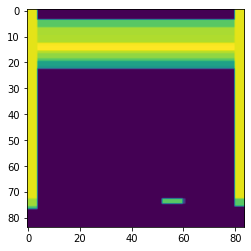

In [59]:
plt.imshow(torch.permute(out[0],(1,2,0)))

In [23]:
1

1